In [3]:
import numpy as np, scipy, time
import cg
from pixell import utils, mpi
from scipy.sparse.linalg import cg, LinearOperator
import matplotlib.pyplot as plt
from scipy.signal import welch
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import matplotlib.gridspec as gridspec

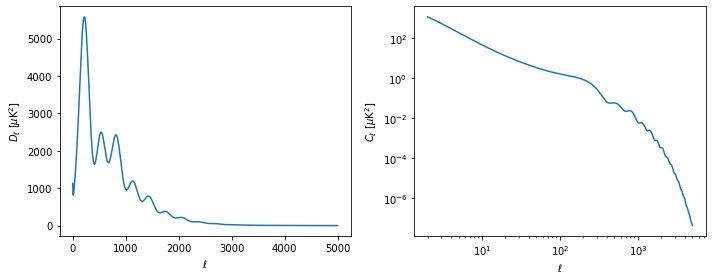

In [2]:
ell, DlTT = np.loadtxt("CAMB_fiducial_cosmo_scalClsdat.sec", usecols=(0, 1), unpack=True)
ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
# ClTT[0] = 0. # set the monopole and the dipole of the Cl spectrum to zero
# ClTT[1] = 0.

fig, axs = plt.subplots(1,2, figsize=(10,4))

# Plot 1
axs[0].plot(ell, DlTT)
axs[0].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]')
axs[0].set_xlabel('$\ell$')

# Plot 2
ClTT = DlTT * 2 * np.pi / (ell*(ell+1.))
axs[1].loglog(ell, ClTT)
axs[1].set_ylabel('$C_{\ell}$ [$\mu$K$^2$]')
axs[1].set_xlabel('$\ell$')

plt.tight_layout()
#plt.savefig('cltt.png', dpi=300, bbox_inches='tight')
plt.show()


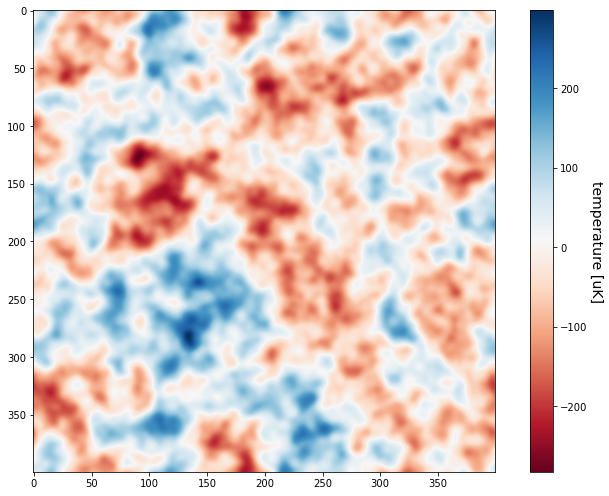

In [3]:
## create map array
map_size = 5.*60.   # map size in arcminutes
pix_size = 0.75    # pixel size in arcminutes
N = int(map_size/pix_size)  # dimension of the map array

## make a 2D array of X and Y coordinates
X,Y = np.meshgrid(np.linspace(-1,1,N),np.linspace(-1,1,N))

## define the radial coordinate R of each pixel. R is real-space counterpart of fourier variable k
R = np.sqrt(X**2. + Y**2.)

pix_to_rad = (pix_size/60. * np.pi/180.)   # this is the pixel size in radians
ell_scale_factor = np.pi /pix_to_rad    # here we connect angular size to the multipoles
ell2d = R * ell_scale_factor     # this is the Fourier analog of the real-vector R in 2D


## create 2D power spectrum
ClTT_expanded = np.zeros(int(ell2d.max())+1)
ClTT_expanded[0:(ClTT.size)] = ClTT  # fill in the Cls until the max of the ClTT vector
ClTT2d = ClTT_expanded[ell2d.astype(int)]

## make random realization of a Gaussian field and Fourier transform
random_array_for_T = np.random.normal(0,1,(N,N))
FT_random_array_for_T = np.fft.fft2(random_array_for_T)   # take FFT since we are in Fourier space 
    
FT_2d = np.sqrt(ClTT2d) * FT_random_array_for_T # we take the sqrt since the power spectrum is T^2

    
# move back from ell space to real space
CMB_T = np.fft.ifft2(np.fft.fftshift(FT_2d)) 
# move back to pixel space for the map
CMB_T = CMB_T/pix_to_rad
# we only want to plot the real component
CMB_T = np.real(CMB_T)


## plot the CMB map
plt.figure(figsize=(10,7))
im = plt.imshow(CMB_T,cmap='RdBu', interpolation='bilinear')
cbar = plt.colorbar(im, orientation='vertical')
cbar.set_label('temperature [uK]', rotation=270, labelpad=15, fontsize=14)
plt.tight_layout()
#plt.savefig('realisticcmb_map.png', dpi=300, bbox_inches='tight')

plt.show()



0.003544394893165573

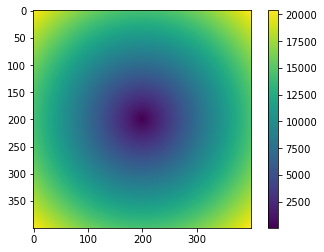

In [4]:
plt.imshow(ell2d)
plt.colorbar()
np.min(R)

In [5]:
#### parameters for setting up the spectrum
delta_ell = 75.
ell_max = 5000.

if max(ell)< ell_max:
        print('WARNING: Your theory curves end before the binned ell_max')

def calculate_2d_spectrum(Map1,Map2,delta_ell,ell_max,pix_size,N):
    "calcualtes the power spectrum of a 2d map by FFTing, squaring, and azimuthally averaging"
    N=int(N)
    # make a 2d ell coordinate system
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.) /(N-1.)
    kX = np.outer(ones,inds) / (pix_size/60. * np.pi/180.)
    kY = np.transpose(kX)
    K = np.sqrt(kX**2. + kY**2.)
    ell_scale_factor = 2. * np.pi 
    ell2d = K * ell_scale_factor
    
    # make an array to hold the power spectrum results
    N_bins = int(ell_max/delta_ell)
    ell_array = np.arange(N_bins)
    CL_array = np.zeros(N_bins)
    
    # get the 2d fourier transform of the map
    FMap1 = np.fft.ifft2(np.fft.fftshift(Map1))
    FMap2 = np.fft.ifft2(np.fft.fftshift(Map2))
    PSMap = np.fft.fftshift(np.real(np.conj(FMap1) * FMap2))
    # fill out the spectra
    i = 0
    while (i < N_bins):
        ell_array[i] = (i + 0.5) * delta_ell
        inds_in_bin = ((ell2d >= (i* delta_ell)) * (ell2d < ((i+1)* delta_ell))).nonzero()
        CL_array[i] = np.mean(PSMap[inds_in_bin])
        #print i, ell_array[i], inds_in_bin, CL_array[i]
        i = i + 1
 
    # return the power spectrum and ell bins
    return(ell_array,CL_array*np.sqrt(pix_size /60.* np.pi/180.)*2.)

## without a cosine window

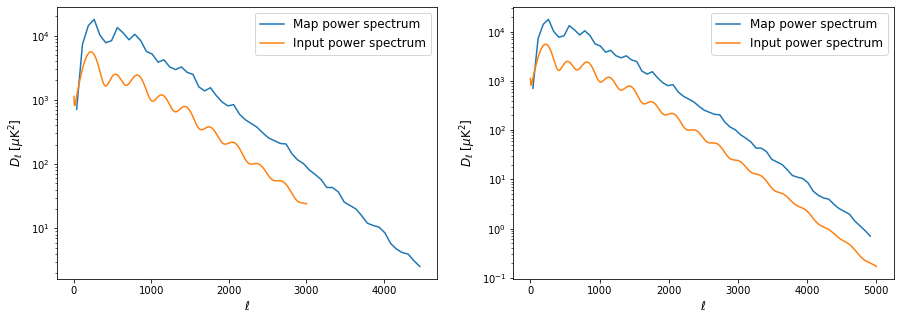

In [6]:
## make a power spectrum
binned_ell, binned_spectrum = calculate_2d_spectrum(CMB_T,CMB_T,delta_ell,ell_max,pix_size,N)
#print binned_ell
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].semilogy(binned_ell[:60],(binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi)[:60],label='Map power spectrum')
ax[0].semilogy(ell[:3000],DlTT[:3000],label='Input power spectrum')
ax[0].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=12)
ax[0].set_xlabel('$\ell$',fontsize=12)
ax[0].legend(fontsize=12)
ax[1].semilogy(binned_ell,(binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi),label='Map power spectrum')
ax[1].semilogy(ell,DlTT,label='Input power spectrum')
ax[1].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=12)
ax[1].set_xlabel('$\ell$',fontsize=12)
ax[1].legend(fontsize=12)
plt.show()

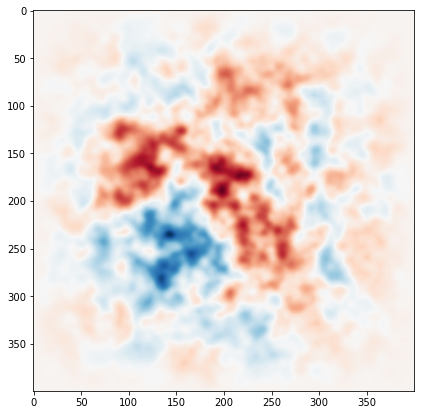

In [7]:
def cosine_window(N):
    "makes a cosine window for apodizing to avoid edges effects in the 2d FFT" 
    # make a 2d coordinate system
    N=int(N) 
    ones = np.ones(N)
    inds  = (np.arange(N)+.5 - N/2.)/N *np.pi ## eg runs from -pi/2 to pi/2
    X = np.outer(ones,inds)
    Y = np.transpose(X)
  
    # make a window map
    window_map = np.cos(X) * np.cos(Y)
   
    # return the window map
    return(window_map)
  ###############################
    
window = (cosine_window(N))
appodized_map = CMB_T * window
plt.figure(figsize=(10,7))
plt.imshow(appodized_map,cmap='RdBu', interpolation='bilinear')

## With a cosine window

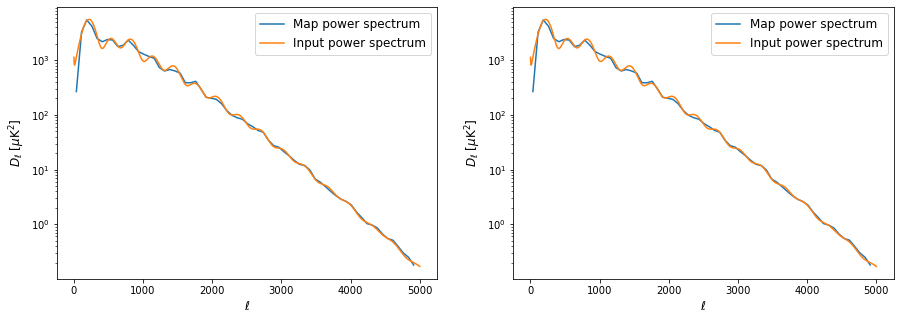

In [8]:
## make a power spectrum
binned_ell, binned_spectrum = calculate_2d_spectrum(appodized_map,appodized_map,delta_ell,ell_max,pix_size,N)
#print binned_ell
fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].semilogy(binned_ell,(binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi),label='Map power spectrum')
ax[0].semilogy(ell,DlTT,label='Input power spectrum')
ax[0].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=12)
ax[0].set_xlabel('$\ell$',fontsize=12)
ax[0].legend(fontsize=12)
ax[1].semilogy(binned_ell,(binned_spectrum* binned_ell * (binned_ell+1.)/2. / np.pi),label='Map power spectrum')
ax[1].semilogy(ell,DlTT,label='Input power spectrum')
ax[1].set_ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=12)
ax[1].set_xlabel('$\ell$',fontsize=12)
ax[1].legend(fontsize=12)
plt.show()

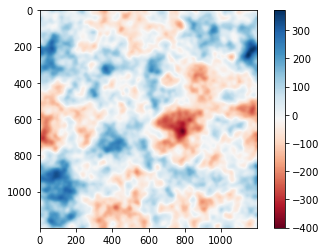

In [10]:
mlsol_w=np.load('map_ml_snw.npy')
mlsol_r=np.load('map_ml_snr.npy')
mlsol_ex=np.load('map_ml_snex.npy')
simulCMB=np.load('simulCMB.npy')

plt.imshow(simulCMB,cmap='RdBu', interpolation='bilinear')
plt.colorbar()

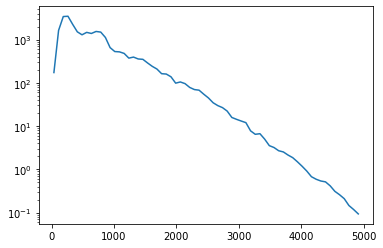

In [10]:
appo_simulCMB = simulCMB * cosine_window(1200)
bin_ell, bin_spectrum = calculate_2d_spectrum(appo_simulCMB,appo_simulCMB,75,5000,0.25,1200)
bin_ell, bin_spectrum=bin_ell,bin_spectrum
plt.semilogy(bin_ell,(bin_spectrum* bin_ell * (bin_ell+1.)/2. / np.pi),label='Map power spectrum')

## Comparision between Simulated map PS and ML map PS

In [11]:
binning = 75
mlsol_w=cosine_window(300)*mlsol_w
mlsol_r=cosine_window(300)*mlsol_r
mlsol_ex=cosine_window(300)*mlsol_ex

binned_ell_w, binned_spectrum_w = calculate_2d_spectrum(mlsol_w,mlsol_w,binning,5000,1,300)
binned_ell_r, binned_spectrum_r = calculate_2d_spectrum(mlsol_r,mlsol_r,binning,5000,1,300)
binned_ell_ex, binned_spectrum_ex = calculate_2d_spectrum(mlsol_ex,mlsol_ex,binning,5000,1,300)

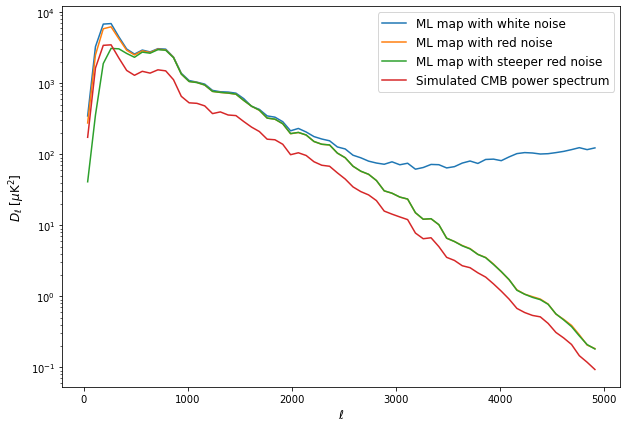

In [12]:


plt.figure(figsize=(10,7))
plt.semilogy(binned_ell_w,((binned_spectrum_w* binned_ell_w * (binned_ell_w+1.)/2. / np.pi)),label='ML map with white noise')
plt.semilogy(binned_ell_r,((binned_spectrum_r* binned_ell_r * (binned_ell_r+1.)/2. / np.pi)),label='ML map with red noise')
plt.semilogy(binned_ell_ex,((binned_spectrum_ex* binned_ell_ex * (binned_ell_ex+1.)/2. / np.pi)),label='ML map with steeper red noise')
plt.semilogy(bin_ell,(bin_spectrum* bin_ell * (bin_ell+1.)/2. / np.pi),label='Simulated CMB power spectrum')
#plt.semilogy(ell[:3000],DlTT[:3000],label='Input power spectrum')
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=12)
plt.xlabel('$\ell$',fontsize=12)
plt.legend(fontsize=12)

# Using PYSM3 maps


In [1]:
import pysm3
import pysm3.units as u
import healpy as hp


In [25]:
sky = pysm3.Sky(nside=4096, preset_strings=["c4","d1","s1"])  # one can choose the models. Documentation at https://pysm3.readthedocs.io/en/latest/models.html
sky.components

In [26]:
map_220GHz = sky.get_emission(220 * u.GHz)
map_220GHz = map_220GHz.to(u.uK_CMB, equivalencies=u.cmb_equivalencies(220*u.GHz))


(12582912,)

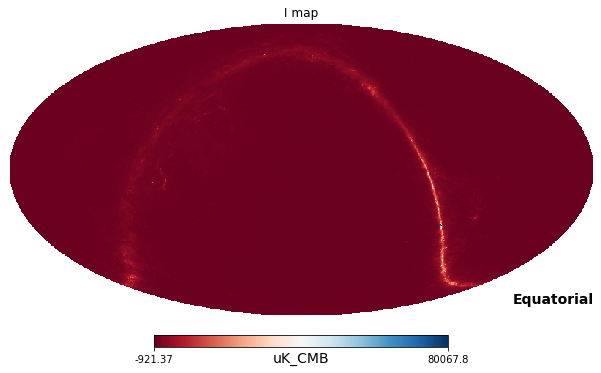

In [18]:
#hp.mollview(map_220GHz[0], min=-300 ,max=300, title="I map", unit=map_220GHz.unit,cmap='RdBu')
hp.mollview(map_220GHz[0],title="I map",coord="GC",unit=map_220GHz.unit,cmap='RdBu',remove_dip=True)
map_220GHz[0].shape



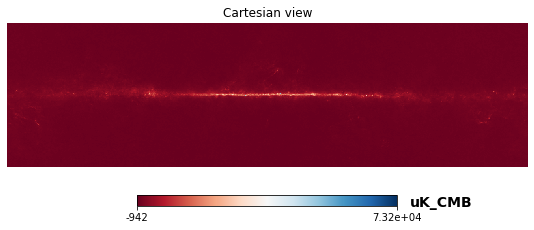

In [19]:
map=hp.visufunc.cartview(map_220GHz[0], unit=map_220GHz.unit,cmap="RdBu",lonra=[-180,180],latra=[-50,50],remove_dip=True)
#map=np.load('map.npy')
map=np.array(map)
#np.save('map.npy',map)

In [30]:
wow=pysm3.apply_smoothing_and_coord_transform(map_220GHz[0], fwhm=0.0158333*u.deg, rot=hp.Rotator(coord=("G","C")))

hp.map2alm_lsq did not converge in 10 iterations, residual relative error is 0.021


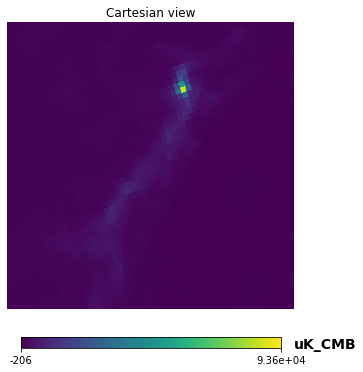

In [35]:
#hp.gnomview( wow, rot=[84.5, -6.98], reso= 2.5, title="GnomView", unit=map_220GHz.unit, format="%.2g")
map=hp.visufunc.cartview(wow, unit=map_220GHz.unit,rot=[84.5, -6.98],lonra=[-3,3],latra=[-3,3],remove_dip=True,return_projected_map=True,xsize=1200)
map=np.array(map)
np.save('OrionA.npy',map)

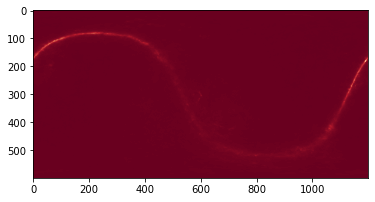

In [33]:
plt.imshow(map,cmap='RdBu', interpolation='bilinear')

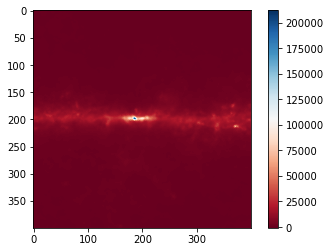

In [9]:
plt.imshow(map,cmap='RdBu', interpolation='bilinear')
plt.colorbar()
signalmap=np.concatenate([map.reshape(-1), map.T.reshape(-1)])
signalmap=np.array(signalmap)
#np.save('signalmap.npy',signalmap)


# Power Spectrum using anafast

Text(0, 0.5, '$C_{\\ell}$ [$\\mu$K$^2$]')

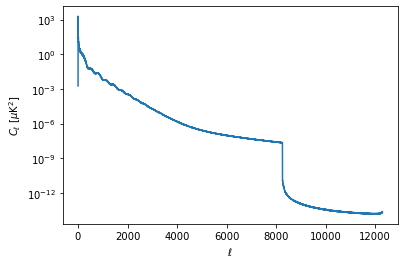

In [19]:
cl=hp.sphtfunc.anafast(map_220GHz[0], map_220GHz[0], alm=False)
plt.semilogy(np.arange(len(cl)),cl)
plt.xlabel('$\ell$')
plt.ylabel('$C_{\ell}$ [$\mu$K$^2$]')

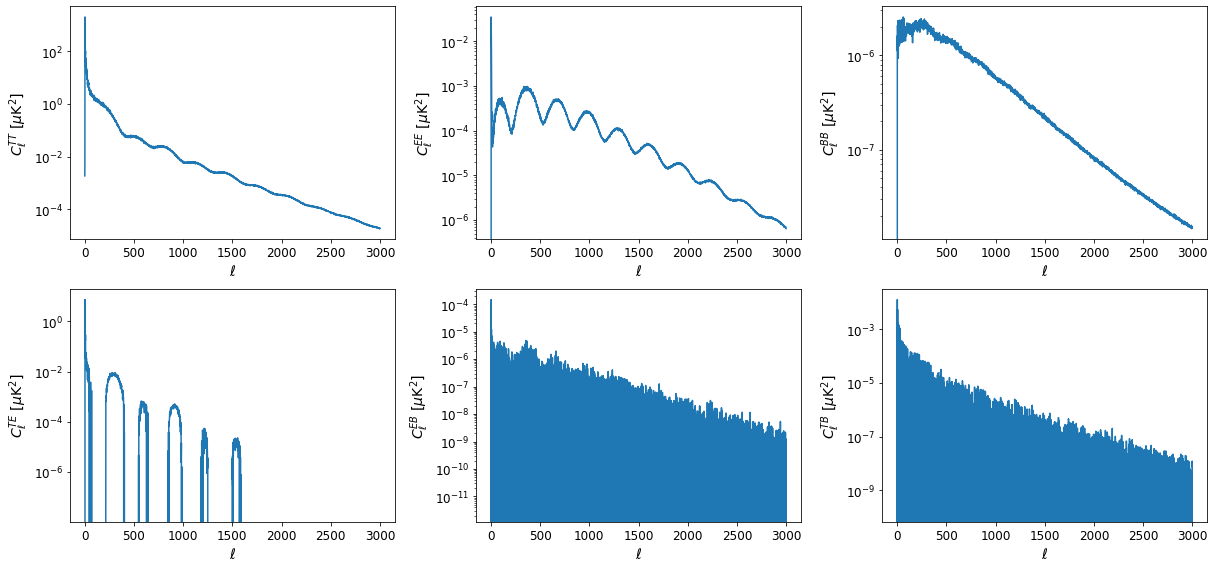

In [20]:
c_tt,c_ee,c_bb,c_te,c_eb,c_tb=hp.sphtfunc.anafast(map_220GHz, map_220GHz, alm=False,lmax=3000)

fig, ax = plt.subplots(2,3, figsize=(17,8))  # Changed to 2 rows and 3 columns
fontsize = 14
labelsize = 12

ax[0,0].semilogy(np.arange(len(c_tt)),c_tt)
ax[0,0].set_xlabel('$\ell$', fontsize=fontsize)
ax[0,0].set_ylabel('$C_{\ell}^{TT}$ [$\mu$K$^2$]', fontsize=fontsize)
ax[0,0].tick_params(axis='both', which='major', labelsize=labelsize)

ax[0,1].semilogy(np.arange(len(c_ee)),c_ee)
ax[0,1].set_xlabel('$\ell$', fontsize=fontsize)
ax[0,1].set_ylabel('$C_{\ell}^{EE}$ [$\mu$K$^2$]', fontsize=fontsize)
ax[0,1].tick_params(axis='both', which='major', labelsize=labelsize)

ax[0,2].semilogy(np.arange(len(c_bb)),c_bb)  # Moved to the third column of the first row
ax[0,2].set_xlabel('$\ell$', fontsize=fontsize)
ax[0,2].set_ylabel('$C_{\ell}^{BB}$ [$\mu$K$^2$]', fontsize=fontsize)
ax[0,2].tick_params(axis='both', which='major', labelsize=labelsize)

ax[1,0].semilogy(np.arange(len(c_te)),c_te)  # Moved to the first column of the second row
ax[1,0].set_xlabel('$\ell$', fontsize=fontsize)
ax[1,0].set_ylabel('$C_{\ell}^{TE}$ [$\mu$K$^2$]', fontsize=fontsize)
ax[1,0].tick_params(axis='both', which='major', labelsize=labelsize)

ax[1,1].semilogy(np.arange(len(c_eb)),c_eb)  # Moved to the second column of the second row
ax[1,1].set_xlabel('$\ell$', fontsize=fontsize)
ax[1,1].set_ylabel('$C_{\ell}^{EB}$ [$\mu$K$^2$]', fontsize=fontsize)
ax[1,1].tick_params(axis='both', which='major', labelsize=labelsize)

ax[1,2].semilogy(np.arange(len(c_tb)),c_tb)  # Moved to the third column of the second row
ax[1,2].set_xlabel('$\ell$', fontsize=fontsize)
ax[1,2].set_ylabel('$C_{\ell}^{TB}$ [$\mu$K$^2$]', fontsize=fontsize)
ax[1,2].tick_params(axis='both', which='major', labelsize=labelsize)

plt.tight_layout()


# using PySM3 maps and ML solver module

In [21]:
import solver as sr

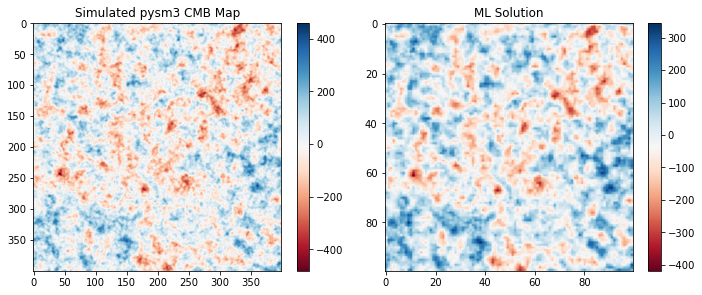

In [22]:
mlsol=sr.MLsolver(map)
ml_soln=mlsol.ml_solver(0)
#ml_soln=cosine_window(100)*mlsol.ml_solver(0)
#map=cosine_window(400)*map
plt.figure(figsize=(10,4))  # Adjust the size to accommodate both subplots

# First subplot
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.imshow(map, cmap='RdBu')
plt.colorbar()
plt.title('Simulated pysm3 CMB Map')

# Second subplot
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.imshow(ml_soln, cmap='RdBu')
plt.colorbar()
plt.title('ML Solution')

plt.tight_layout()  # Optional: to prevent overlap of subplots

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5, 0, '$\\ell$')

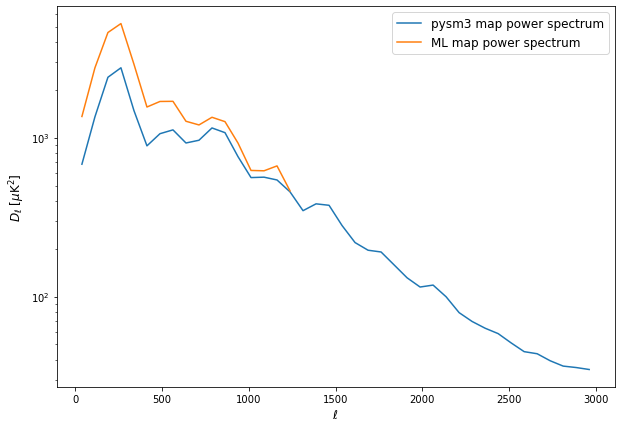

In [23]:
bin_ell_m, bin_spectrum_m = calculate_2d_spectrum(map,map,75,3000,3,400)
bin_ell, bin_spectrum = calculate_2d_spectrum(ml_soln,ml_soln,75,3000,12,100)
plt.figure(figsize=(10,7))
plt.semilogy(bin_ell_m,(bin_spectrum_m* bin_ell_m * (bin_ell_m+1.)/2. / np.pi),label='pysm3 map power spectrum')
plt.semilogy(bin_ell,(bin_spectrum* bin_ell * (bin_ell+1.)/2. / np.pi),label='ML map power spectrum')
plt.legend(fontsize=12)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=12)
plt.xlabel('$\ell$',fontsize=12)


#### This happened due to the big angular size of the map i.e. 20 degrees and the usage of 100 pixels resolution for the map. Both factors combined to the code not being able to calculate the ps for all $\ell$ values.

## Map with 100 pixels and its PS

In [24]:
# map100=hp.visufunc.cartview(map_220GHz[0], unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=100)
# map400=hp.visufunc.cartview(map_220GHz[0], unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=400)
# map800=hp.visufunc.cartview(map_220GHz[0], unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=800)
# map1200=hp.visufunc.cartview(map_220GHz[0], unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=1200)
# map100=np.array(map100)
# map400=np.array(map400)
# map800=np.array(map800)
# map1200=np.array(map1200)
map100=np.load('pysm3_map100.npy')
map400=np.load('pysm3_map400.npy')
map400=np.array(map400)*cosine_window(400)
map100=np.array(map100)*cosine_window(100)
binned_ell_m100, binned_spectrum_m100 = calculate_2d_spectrum(map100,map100,75,5000,2.4,100)
binned_ell_m400, binned_spectrum_m400 = calculate_2d_spectrum(map400,map400,75,5000,0.6,400)
# np.save('pysm3_map100.npy',map100)
# np.save('pysm3_map400.npy',map400)
# np.save('pysm3_map800.npy',map800)
# np.save('pysm3_map1200.npy',map1200)


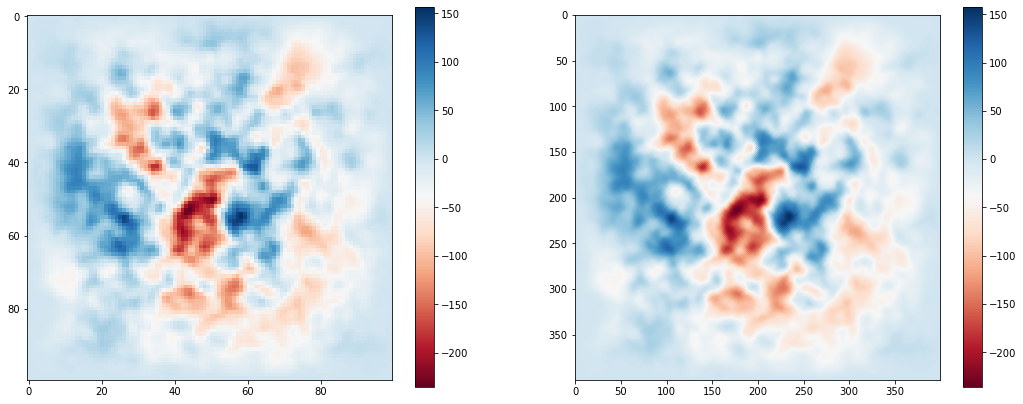

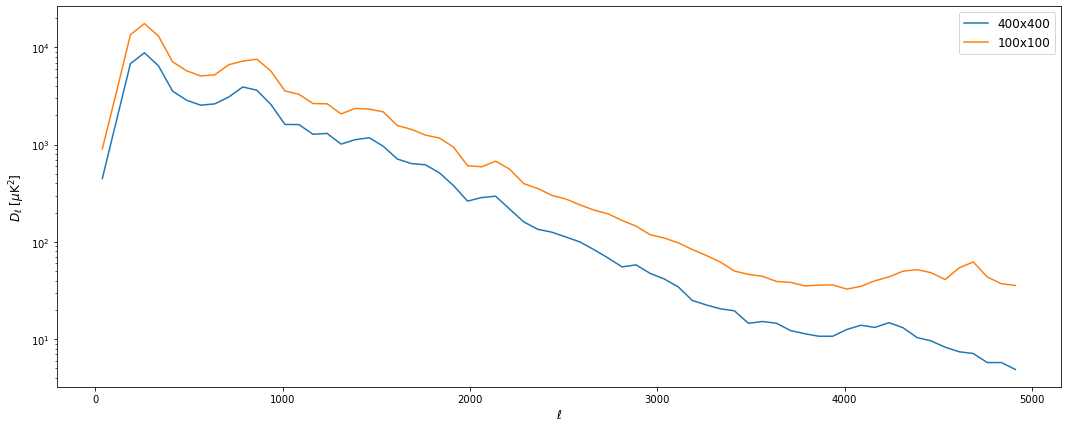

In [25]:
plt.figure(figsize=(18,7))  # Adjust the size to accommodate both subplots
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.imshow(map100, cmap='RdBu')
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(map400, cmap='RdBu')
plt.colorbar()



plt.figure(figsize=(18,7))  # Adjust the size to accommodate both subplots
plt.semilogy(binned_ell_m400,(binned_spectrum_m400* binned_ell_m400 * (binned_ell_m400+1.)/2. / np.pi),label='400x400')
plt.semilogy(binned_ell_m100,(binned_spectrum_m100* binned_ell_m100 * (binned_ell_m100+1.)/2. / np.pi),label='100x100')
plt.xlabel('$\ell$',fontsize=12)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=12)
plt.legend(fontsize=12)

## Solving for a 100x100 map and a 400x400 map

In [26]:
map800=np.load('pysm3_map800.npy')
map1200=np.load('pysm3_map1200.npy')
#map800=hp.visufunc.cartview(map_220GHz[0], unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=800)
map800=np.array(map800)*cosine_window(800)
#map1200=hp.visufunc.cartview(map_220GHz[0], unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=1200)
map1200=np.array(map1200)*cosine_window(1200)

In [27]:
# np.save('pysm3_map800.npy',np.array(map800))
# np.save('pysm3_map1200.npy',np.array(map1200))
# np.save('pysm3_map400.npy',np.array(map400))
# np.save('pysm3_map100.npy',np.array(map100))

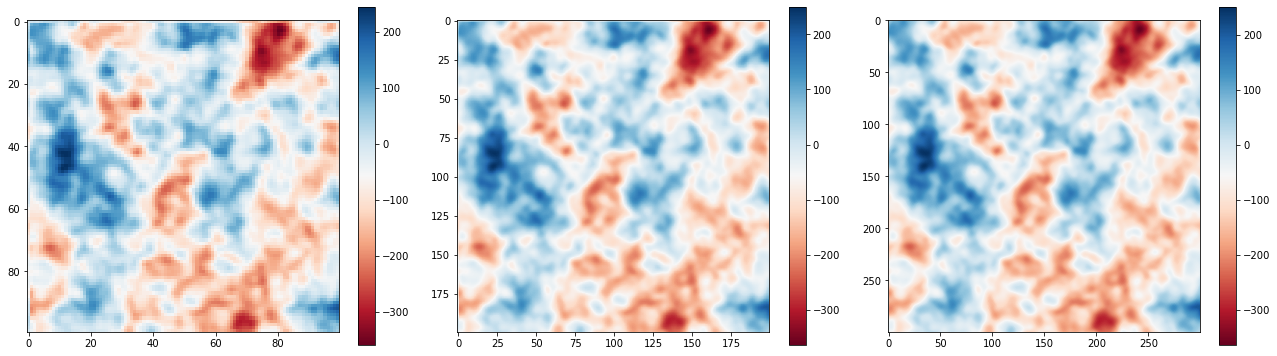

In [28]:
data400=sr.MLsolver(map400/cosine_window(400))
ml_map_400=data400.ml_solver(0)
data800=sr.MLsolver(map800/cosine_window(800),200)
ml_map_800=data800.ml_solver(0)
data1200=sr.MLsolver(map1200/cosine_window(1200),300)
ml_map_1200=data1200.ml_solver(0)

plt.figure(figsize=(18,5))  # Adjust the size to accommodate both subplots
plt.subplot(1, 3, 1)  # 1 row, 2 columns, first plot
plt.imshow(ml_map_400, cmap='RdBu')
plt.colorbar()

plt.subplot(1,3,2)
plt.imshow(ml_map_800, cmap='RdBu')
plt.colorbar()

plt.subplot(1,3,3)
plt.imshow(ml_map_1200, cmap='RdBu')
plt.colorbar()

plt.tight_layout()





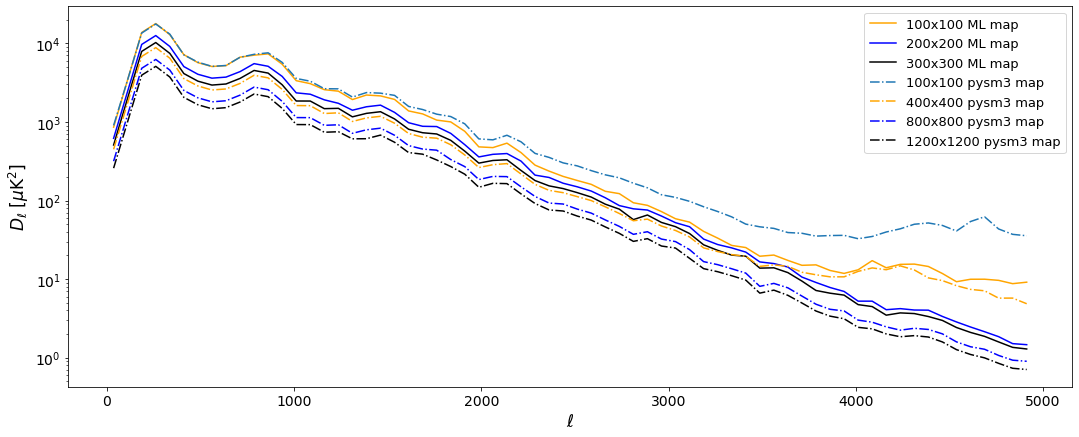

In [29]:
bin=75
bin_ell_100, bin_spectrum_100 = calculate_2d_spectrum(ml_map_400*cosine_window(100),ml_map_400*cosine_window(100),bin,5000,2.4,100)
bin_ell_200, bin_spectrum_200 = calculate_2d_spectrum(ml_map_800*cosine_window(200),ml_map_800*cosine_window(200),bin,5000,1.2,200)
bin_ell_300, bin_spectrum_300 = calculate_2d_spectrum(ml_map_1200*cosine_window(300),ml_map_1200*cosine_window(300),bin,5000,0.8,300)
binned_ell_m100, binned_spectrum_m100 = calculate_2d_spectrum(map100,map100,bin,5000,2.4,100)
binned_ell_m400, binned_spectrum_m400 = calculate_2d_spectrum(map400,map400,bin,5000,0.6,400)
binned_ell_m800, binned_spectrum_m800 = calculate_2d_spectrum(map800,map800,bin,5000,0.3,800)
binned_ell_m1200, binned_spectrum_m1200 = calculate_2d_spectrum(map1200,map1200,bin,5000,0.2,1200)

plt.figure(figsize=(18,7))  # Adjust the size to accommodate both subplots
plt.semilogy(bin_ell_100,(bin_spectrum_100* bin_ell_100 * (bin_ell_100+1.)/2. / np.pi),label='100x100 ML map',c='orange')
plt.semilogy(bin_ell_200,(bin_spectrum_200* bin_ell_200 * (bin_ell_200+1.)/2. / np.pi),label='200x200 ML map',c='blue')
plt.semilogy(bin_ell_300,(bin_spectrum_300* bin_ell_300 * (bin_ell_300+1.)/2. / np.pi),label='300x300 ML map',c='black')
plt.semilogy(binned_ell_m100,(binned_spectrum_m100* binned_ell_m100 * (binned_ell_m100+1.)/2. / np.pi),label='100x100 pysm3 map',ls='-.')
plt.semilogy(binned_ell_m400,(binned_spectrum_m400* binned_ell_m400 * (binned_ell_m400+1.)/2. / np.pi),label='400x400 pysm3 map',ls='-.',c='orange')
plt.semilogy(binned_ell_m800,(binned_spectrum_m800* binned_ell_m800 * (binned_ell_m800+1.)/2. / np.pi),label='800x800 pysm3 map',ls='-.',c='blue')
plt.semilogy(binned_ell_m1200,(binned_spectrum_m1200* binned_ell_m1200 * (binned_ell_m1200+1.)/2. / np.pi),label='1200x1200 pysm3 map',ls='-.',c='black')
plt.xlabel('$\ell$',fontsize=17)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=13)

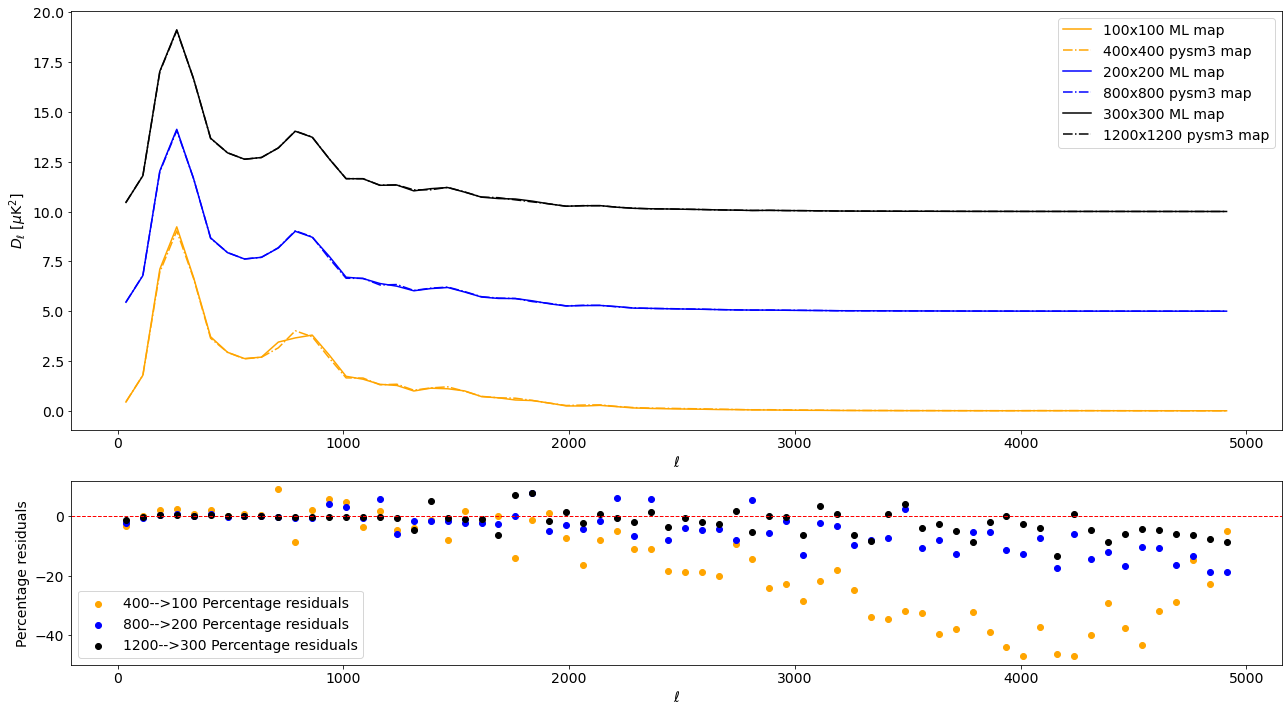

In [30]:

#Normalizing the power spectrums
normml100=(bin_spectrum_100* bin_ell_100 * (bin_ell_100+1.)/2. / np.pi)/np.mean(bin_spectrum_100* bin_ell_100 * (bin_ell_100+1.)/2. / np.pi)
normml200=(bin_spectrum_200* bin_ell_200 * (bin_ell_200+1.)/2. / np.pi)/np.mean(bin_spectrum_200* bin_ell_200 * (bin_ell_200+1.)/2. / np.pi)
normml300=(bin_spectrum_300* bin_ell_300 * (bin_ell_300+1.)/2. / np.pi)/np.mean(bin_spectrum_300* bin_ell_300 * (bin_ell_300+1.)/2. / np.pi)
norm400=(binned_spectrum_m400* binned_ell_m400 * (binned_ell_m400+1.)/2. / np.pi)/np.mean(binned_spectrum_m400* binned_ell_m400 * (binned_ell_m400+1.)/2. / np.pi)
norm800=(binned_spectrum_m800* binned_ell_m800 * (binned_ell_m800+1.)/2. / np.pi)/np.mean(binned_spectrum_m800* binned_ell_m800 * (binned_ell_m800+1.)/2. / np.pi)
norm1200=(binned_spectrum_m1200* binned_ell_m1200 * (binned_ell_m1200+1.)/2. / np.pi)/np.mean(binned_spectrum_m1200* binned_ell_m1200 * (binned_ell_m1200+1.)/2. / np.pi)


#percentage residuals
residuals100=(normml100-norm400)/norm400*100
residuals200=(normml200-norm800)/norm800*100
residuals300=(normml300-norm1200)/norm1200*100




# Create a figure
fig = plt.figure(figsize=(18,10))

# Define the grid
gs = gridspec.GridSpec(3, 1)

# Create the first subplot
ax1 = fig.add_subplot(gs[:2, :])
ax1.tick_params(axis='y', labelsize=14)  # Change the size of the y-axis ticks
ax1.tick_params(axis='x', labelsize=14)  # Change the size of the x-axis ticks
ax1.plot(bin_ell_100,normml100,label='100x100 ML map',c='orange')
ax1.plot(binned_ell_m400,norm400,label='400x400 pysm3 map',ls='-.',c='orange')
ax1.plot(bin_ell_200,normml200+5,label='200x200 ML map',c='blue')
ax1.plot(binned_ell_m800,norm800+5,label='800x800 pysm3 map',ls='-.',c='blue')
ax1.plot(bin_ell_300,normml300+10,label='300x300 ML map',c='black')
ax1.plot(binned_ell_m1200,norm1200+10,label='1200x1200 pysm3 map',ls='-.',c='black')
ax1.set_xlabel('$\ell$',fontsize=14)
ax1.set_ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=14)
ax1.legend(fontsize=14)

# Create the second subplot
ax2 = fig.add_subplot(gs[2, :])
ax2.tick_params(axis='y', labelsize=14)  # Change the size of the y-axis ticks
ax2.tick_params(axis='x', labelsize=14)  # Change the size of the x-axis ticks
ax2.scatter(bin_ell_100,residuals100,label='400-->100 Percentage residuals',c='orange')
ax2.scatter(bin_ell_200,residuals200,label='800-->200 Percentage residuals',c='blue')
ax2.scatter(bin_ell_300,residuals300,label='1200-->300 Percentage residuals',c='black')
ax2.axhline(0, color='r', lw=1, ls='--')
ax2.set_xlabel('$\ell$',fontsize=14)
ax2.set_ylabel('Percentage residuals',fontsize=14)

ax2.legend(fontsize=14)

# Show the plots
plt.tight_layout()
plt.show()


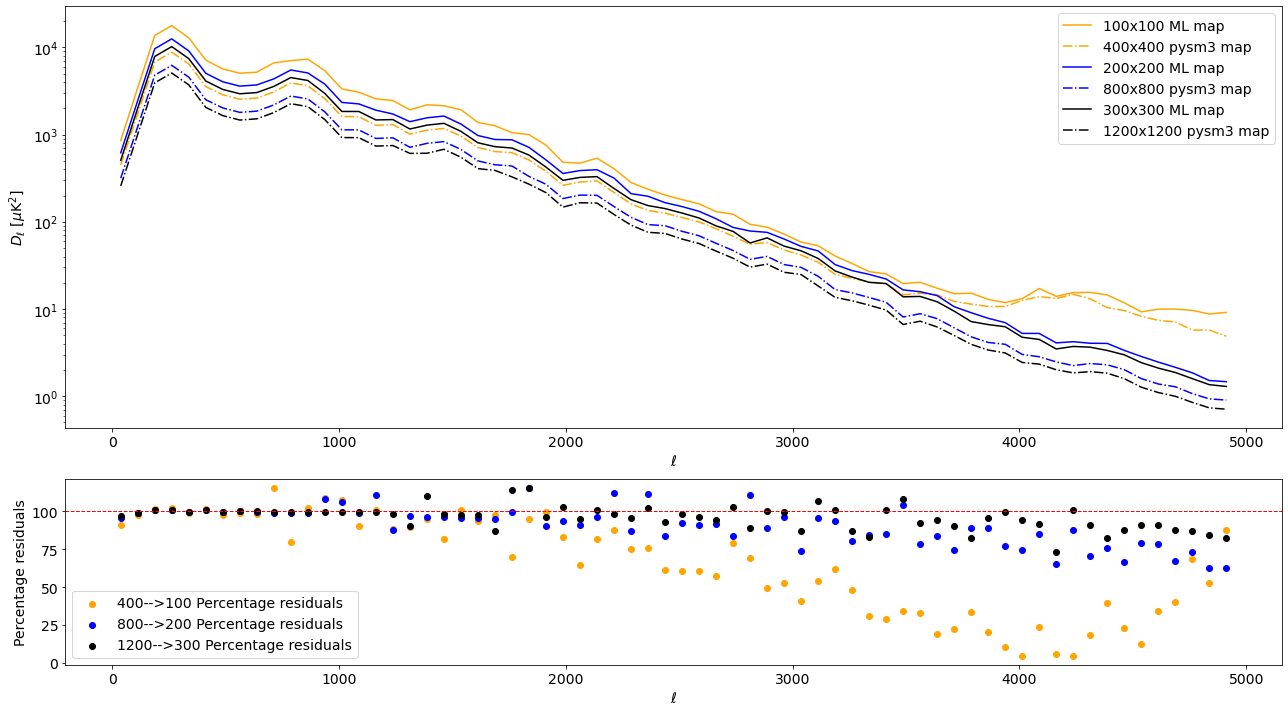

In [31]:
dell100=(bin_spectrum_100* bin_ell_100 * (bin_ell_100+1.)/2. / np.pi)
dell200=(bin_spectrum_200* bin_ell_200 * (bin_ell_200+1.)/2. / np.pi)
dell300=(bin_spectrum_300* bin_ell_300 * (bin_ell_300+1.)/2. / np.pi)
#dell100p=(binned_spectrum_m100* binned_ell_m100 * (binned_ell_m100+1.)/2. / np.pi)
dell400p=(binned_spectrum_m400* binned_ell_m400 * (binned_ell_m400+1.)/2. / np.pi)
dell800p=(binned_spectrum_m800* binned_ell_m800 * (binned_ell_m800+1.)/2. / np.pi)
dell1200p=(binned_spectrum_m1200* binned_ell_m1200 * (binned_ell_m1200+1.)/2. / np.pi)

#Percentage residuals
pres400=(dell100-dell400p)/dell400p *100
pres800=(dell200-dell800p)/dell800p *100
pres1200=(dell300-dell1200p)/dell1200p *100



# Create a figure
fig = plt.figure(figsize=(18,10))

# Define the grid
gs = gridspec.GridSpec(3, 1)

# Create the first subplot
ax1 = fig.add_subplot(gs[:2, :])
ax1.tick_params(axis='y', labelsize=14)  # Change the size of the y-axis ticks
ax1.tick_params(axis='x', labelsize=14)  # Change the size of the x-axis ticks
ax1.semilogy(bin_ell_100,dell100,label='100x100 ML map',c='orange')
ax1.semilogy(binned_ell_m400,dell400p,label='400x400 pysm3 map',ls='-.',c='orange')
ax1.semilogy(bin_ell_200,dell200,label='200x200 ML map',c='blue')
ax1.semilogy(binned_ell_m800,dell800p,label='800x800 pysm3 map',ls='-.',c='blue')
ax1.semilogy(bin_ell_300,dell300,label='300x300 ML map',c='black')
ax1.semilogy(binned_ell_m1200,dell1200p,label='1200x1200 pysm3 map',ls='-.',c='black')
ax1.set_xlabel('$\ell$',fontsize=14)
ax1.set_ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=14)
ax1.legend(fontsize=14)

# Create the second subplot
ax2 = fig.add_subplot(gs[2, :])
ax2.tick_params(axis='y', labelsize=14)  # Change the size of the y-axis ticks
ax2.tick_params(axis='x', labelsize=14)  # Change the size of the x-axis ticks
ax2.scatter(bin_ell_100,pres400,label='400-->100 Percentage residuals',c='orange')
ax2.scatter(bin_ell_200,pres800,label='800-->200 Percentage residuals',c='blue')
ax2.scatter(bin_ell_300,pres1200,label='1200-->300 Percentage residuals',c='black')
ax2.axhline(100, color='r', lw=1, ls='--')
ax2.set_xlabel('$\ell$',fontsize=14)
ax2.set_ylabel('Percentage residuals',fontsize=14)

ax2.legend(fontsize=14)

# Show the plots
plt.tight_layout()
plt.show()


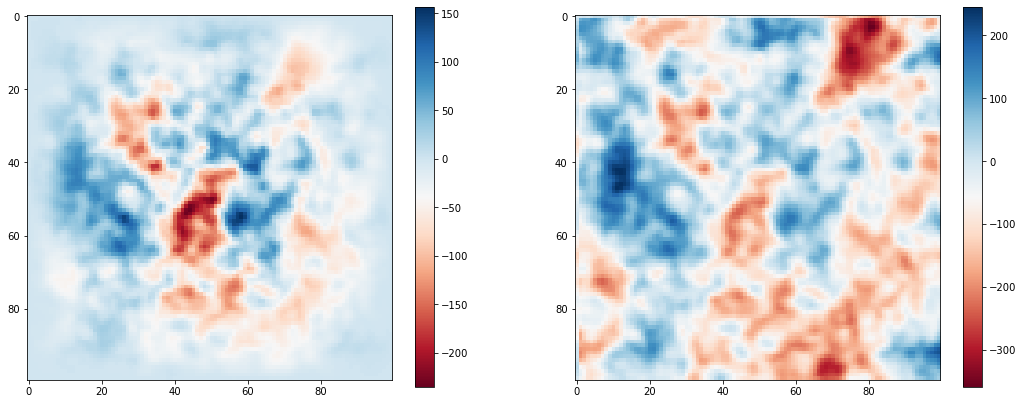

In [32]:
plt.figure(figsize=(18,7))  # Adjust the size to accommodate both subplots
plt.subplot(1,2,1)
plt.imshow(map100, cmap='RdBu')
plt.colorbar()
plt.subplot(1,2,2)
plt.imshow(ml_map_400, cmap='RdBu')
plt.colorbar()

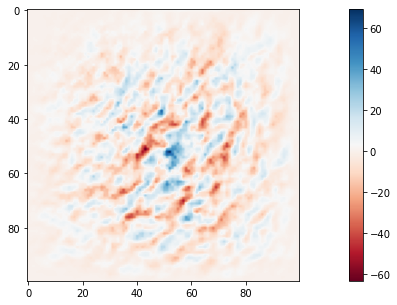

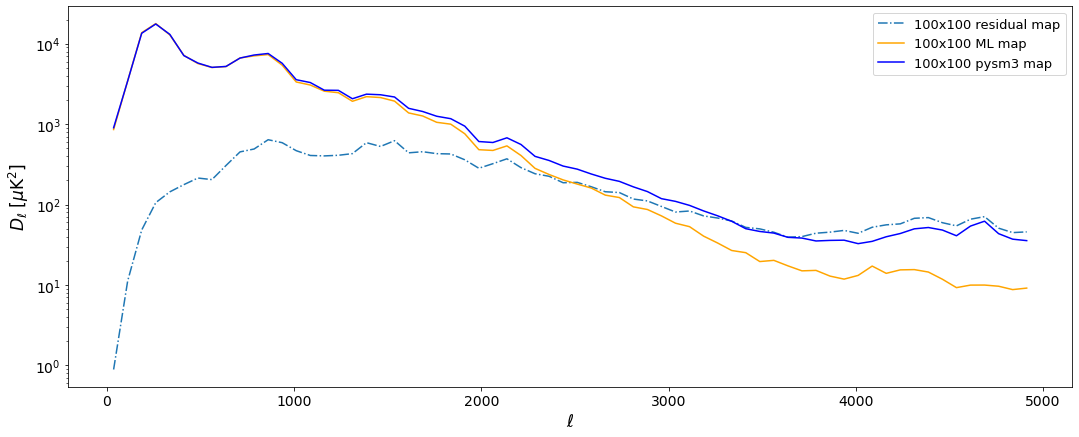

In [33]:
# residual maps
residual_100=map100/cosine_window(100)-ml_map_400
residual_100=cosine_window(100)*residual_100
plt.figure(figsize=(18,5))  # Adjust the size to accommodate both subplots
plt.imshow(residual_100, cmap='RdBu')
plt.colorbar()

# Power spectrum of residual maps
bin_ell_r100, bin_spectrum_r100 = calculate_2d_spectrum(residual_100,residual_100,75,5000,2.4,100)
plt.figure(figsize=(18,7))  # Adjust the size to accommodate both subplots
plt.semilogy(bin_ell_r100,(bin_spectrum_r100* bin_ell_r100 * (bin_ell_r100+1.)/2. / np.pi),label='100x100 residual map',ls='-.')
plt.semilogy(bin_ell_100,(bin_spectrum_100* bin_ell_100 * (bin_ell_100+1.)/2. / np.pi),label='100x100 ML map',c='orange')
plt.semilogy(binned_ell_m100,(binned_spectrum_m100* binned_ell_m100 * (binned_ell_m100+1.)/2. / np.pi),label='100x100 pysm3 map',c='blue')

plt.xlabel('$\ell$',fontsize=17)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=13)

# smoothing with a gaussian

### smoothed with a gaussian of FWHM = 56 arcseconds (Choi et al 2020)

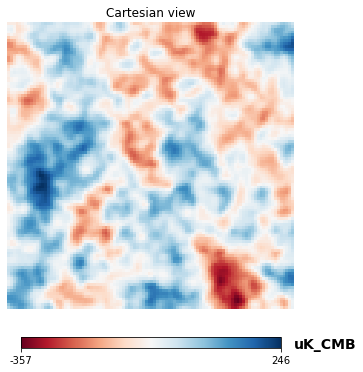

In [42]:
smoo_map=hp.sphtfunc.smoothing(map_220GHz[0], sigma=0.0158333*np.pi/180,lmax=5000)
smoo_map100=hp.visufunc.cartview(smoo_map, unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=100)


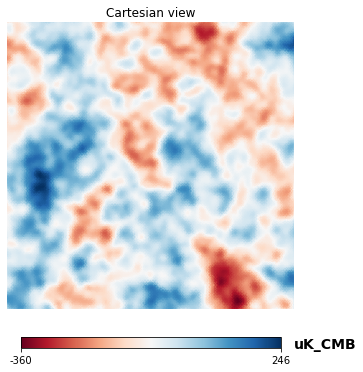

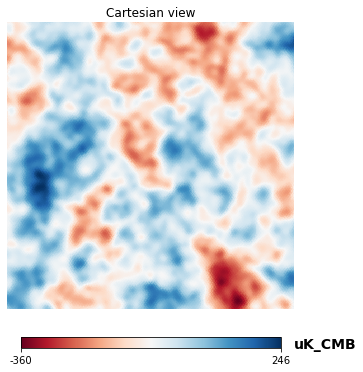

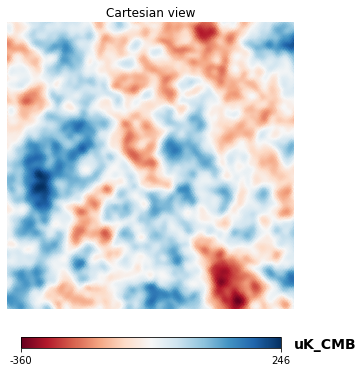

In [43]:
smoo_map100=np.array(smoo_map100)
smoo_map_400=hp.visufunc.cartview(smoo_map, unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=400)
smoo_map_400=np.array(smoo_map_400)
smoo_map_800=hp.visufunc.cartview(smoo_map, unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=800)
smoo_map_800=np.array(smoo_map_800)
smoo_map_1200=hp.visufunc.cartview(smoo_map, unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=1200)
smoo_map_1200=np.array(smoo_map_1200)

In [ ]:
np.save('smoo_map100.npy',smoo_map100)
np.save('smoo_map400.npy',smoo_map_400)
np.save('smoo_map800.npy',smoo_map_800)
np.save('smoo_map1200.npy',smoo_map_1200)

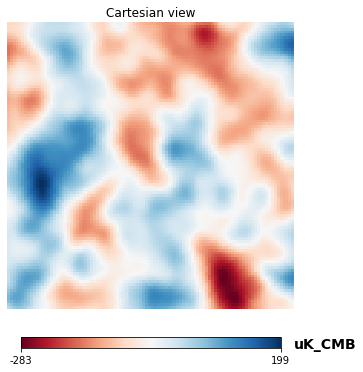

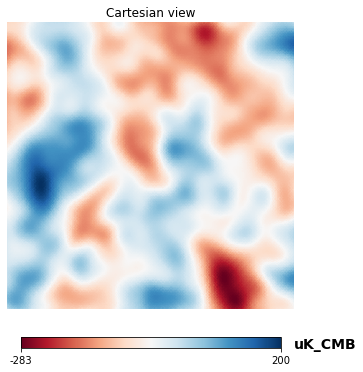

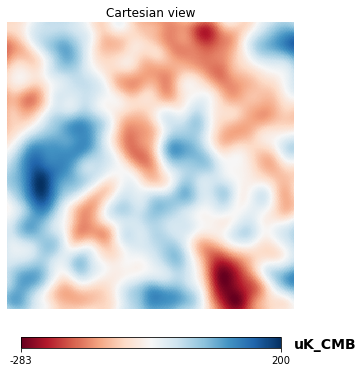

In [36]:
smoo_map100=hp.visufunc.cartview(smoo_map, unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=100)
smoo_map100=np.array(smoo_map100)*cosine_window(100)
smoo_map400=hp.visufunc.cartview(smoo_map, unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=400)
smoo_map400=np.array(smoo_map400)*cosine_window(400)
smoo_map800=hp.visufunc.cartview(smoo_map, unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=800)
smoo_map800=np.array(smoo_map800)*cosine_window(800)


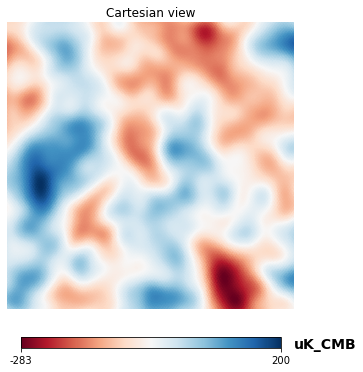

In [37]:
smoo_map1200=hp.visufunc.cartview(smoo_map, unit=map_220GHz.unit, cmap='RdBu',lonra=[-2,2],latra=[-2,2],remove_dip=True,return_projected_map=True,xsize=1200)
smoo_map1200=np.array(smoo_map1200)*cosine_window(1200)

In [38]:
#ML solution of the smoothed maps
data100=sr.MLsolver(smoo_map400/cosine_window(400))
ml_map_100=data100.ml_solver(0)
data200=sr.MLsolver(smoo_map800/cosine_window(800),200)
ml_map_200=data200.ml_solver(0)
data300=sr.MLsolver(smoo_map1200/cosine_window(1200),300)
ml_map_300=data300.ml_solver(0)

/usr/lib/python3/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/lib/python3/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


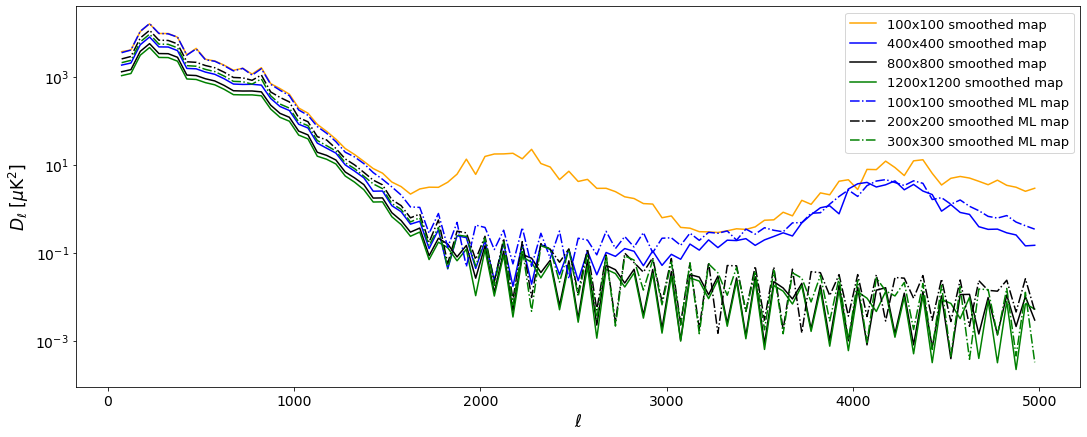

In [39]:
#calculating the power spectrum of the smoothed maps
bin_ell_smoo100, bin_spectrum_smoo100 = calculate_2d_spectrum(smoo_map100,smoo_map100,50,5000,2.4,100)
bin_ell_smoo400, bin_spectrum_smoo400 = calculate_2d_spectrum(smoo_map400,smoo_map400,50,5000,0.6,400)
bin_ell_smoo800, bin_spectrum_smoo800 = calculate_2d_spectrum(smoo_map800,smoo_map800,50,5000,0.3,800)
bin_ell_smoo1200, bin_spectrum_smoo1200 = calculate_2d_spectrum(smoo_map1200,smoo_map1200,50,5000,0.2,1200)
#calculating the power spectrum of the ML solution of the smoothed maps
bin_ell_mlsmoo100, bin_spectrum_mlsmoo100 = calculate_2d_spectrum(ml_map_100*cosine_window(100),ml_map_100*cosine_window(100),50,5000,2.4,100)
bin_ell_mlsmoo200, bin_spectrum_mlsmoo200 = calculate_2d_spectrum(ml_map_200*cosine_window(200),ml_map_200*cosine_window(200),50,5000,1.2,200)
bin_ell_mlsmoo300, bin_spectrum_mlsmoo300 = calculate_2d_spectrum(ml_map_300*cosine_window(300),ml_map_300*cosine_window(300),50,5000,0.8,300)

plt.figure(figsize=(18,7))  # Adjust the size to accommodate both subplots
plt.semilogy(bin_ell_smoo100,(bin_spectrum_smoo100* bin_ell_smoo100 * (bin_ell_smoo100+1.)/2. / np.pi),label='100x100 smoothed map',c='orange')
plt.semilogy(bin_ell_smoo400,(bin_spectrum_smoo400* bin_ell_smoo400 * (bin_ell_smoo400+1.)/2. / np.pi),label='400x400 smoothed map',c='blue')
plt.semilogy(bin_ell_smoo800,(bin_spectrum_smoo800* bin_ell_smoo800 * (bin_ell_smoo800+1.)/2. / np.pi),label='800x800 smoothed map',c='black')
plt.semilogy(bin_ell_smoo1200,(bin_spectrum_smoo1200* bin_ell_smoo1200 * (bin_ell_smoo1200+1.)/2. / np.pi),label='1200x1200 smoothed map',c='green')
plt.semilogy(bin_ell_mlsmoo100,(bin_spectrum_mlsmoo100* bin_ell_mlsmoo100 * (bin_ell_mlsmoo100+1.)/2. / np.pi),label='100x100 smoothed ML map',ls='-.',c='blue')
plt.semilogy(bin_ell_mlsmoo200,(bin_spectrum_mlsmoo200* bin_ell_mlsmoo200 * (bin_ell_mlsmoo200+1.)/2. / np.pi),label='200x200 smoothed ML map',ls='-.',c='black')
plt.semilogy(bin_ell_mlsmoo300,(bin_spectrum_mlsmoo300* bin_ell_mlsmoo300 * (bin_ell_mlsmoo300+1.)/2. / np.pi),label='300x300 smoothed ML map',ls='-.',c='green')

plt.xlabel('$\ell$',fontsize=17)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=13)


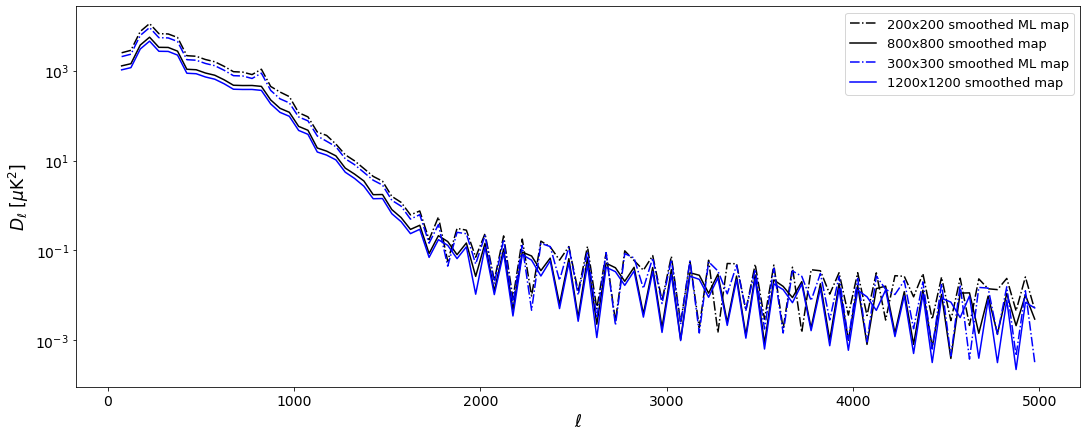

In [40]:
plt.figure(figsize=(18,7))  # Adjust the size to accommodate both subplots
plt.semilogy(bin_ell_mlsmoo200,(bin_spectrum_mlsmoo200* bin_ell_mlsmoo200 * (bin_ell_mlsmoo200+1.)/2. / np.pi),label='200x200 smoothed ML map',ls='-.',c='black')
plt.semilogy(bin_ell_smoo800,(bin_spectrum_smoo800* bin_ell_smoo800 * (bin_ell_smoo800+1.)/2. / np.pi),label='800x800 smoothed map',c='black')
plt.semilogy(bin_ell_mlsmoo300,(bin_spectrum_mlsmoo300* bin_ell_mlsmoo300 * (bin_ell_mlsmoo300+1.)/2. / np.pi),label='300x300 smoothed ML map',ls='-.',c='blue')
plt.semilogy(bin_ell_smoo1200,(bin_spectrum_smoo1200* bin_ell_smoo1200 * (bin_ell_smoo1200+1.)/2. / np.pi),label='1200x1200 smoothed map',c='blue')
plt.xlabel('$\ell$',fontsize=17)
plt.ylabel('$D_{\ell}$ [$\mu$K$^2$]',fontsize=17)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(fontsize=13)

